In [1]:
%matplotlib inline

/Users/nhdaly/homebrew/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
FFMPEG_BIN = 'ffmpeg'
frame_width  = 48
frame_height = 54
frame_depth  =  3 # (number of colors)
frame_dim = (frame_height, frame_width, frame_depth)  # height x width x num_colors(depth)

In [4]:
import subprocess as sp
command = [ FFMPEG_BIN,
            '-i', 'fareeds_take.2015.09.21.speech.full_res.crop.048x054.mov',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
video_pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

In [5]:
# Import the movie file into a python array of images.

from IPython import display

frames = []
while video_pipe:
    # read 1 frame bytes
    raw_image = video_pipe.stdout.read(frame_dim[0]*frame_dim[1]*frame_dim[2])
    if not raw_image:
        break
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape(frame_dim)
    frames.append(image)
    # throw away the data in the pipe's buffer.
    video_pipe.stdout.flush()
    
len(frames)

4740

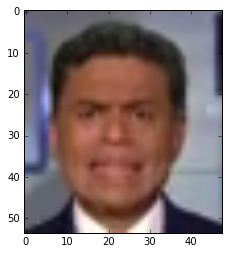

In [6]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

play_frames_clip(frames[10:20])

In [65]:
np.random.random()

0.6370614305512423

In [66]:
# True means it came from the GAN (it was generated).
false_frames  = frames
#false_frames  = [normalize(x) for x in frames]
noise_frames  = [np.random.random(frames[0].shape) * 255 for _ in range(len(frames))]
solid_frames  = [np.zeros(frames[0].shape) + (np.random.random()*255) for _ in range(len(frames))]
true_frames = solid_frames

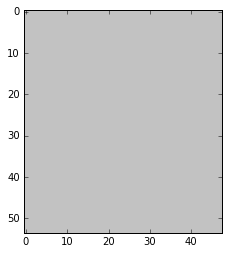

In [67]:
play_frames_clip(true_frames[10:20])

In [68]:
labelled_inputs = [(x.flatten(),1) for x in true_frames] + [(x.flatten(),0) for x in false_frames]
np.random.shuffle(labelled_inputs)

In [78]:
num_total_inputs = len(labelled_inputs)

train_inputs = labelled_inputs[0:num_total_inputs*6/10]
cv_inputs    = labelled_inputs[num_total_inputs*6/10:num_total_inputs*8/10]
test_inputs  = labelled_inputs[num_total_inputs*8/10:]

Xtrain = [x for x,y in train_inputs]
ytrain = [y for x,y in train_inputs]
Xcv    = [x for x,y in cv_inputs]
ycv    = [y for x,y in cv_inputs]
Xtest  = [x for x,y in test_inputs]
ytest  = [y for x,y in test_inputs]

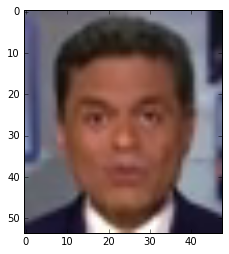

In [81]:
play_frames_clip([x.reshape(frame_dim) for x in Xtrain[10:20]])

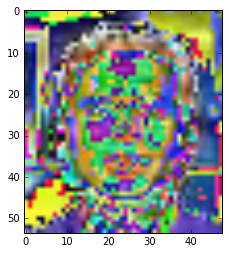

In [82]:
def normalize(x):
    mu = np.mean(x)
    sigma = np.std(x)
    x_norm = (x - mu) / sigma  # All element-wise
    return x_norm
play_frames_clip([normalize(x) for x in frames[30:40]])

### Build the Discriminator

In [63]:
import tensorflow as tf

ImportError: No module named tensorflow

In [ ]:
dim_X  = flattened_image_len
dim_h1 = 5
dim_h2 = 5
dim_h3 = 5
dim_y  = 1

In [ ]:
flattened_image_len = frames[0].flatten().shape[0]
print flattened_image_len
W1 = tf.Variable(tf.random_uniform([dim_X,dim_h1], maxval=0.01, minval=-0.01), name='W1') 
b1 = tf.Variable(tf.zeros([dim_h2]), name='b1')
W2 = tf.Variable(tf.random_uniform([dim_h1,dim_h2], maxval=0.01, minval=-0.01), name='W2') 
b2 = tf.Variable(tf.zeros([dim_h3]), name='b2')
W3 = tf.Variable(tf.random_uniform([dim_h2,dim_h3], maxval=0.01, minval=-0.01), name='W3') 
b3 = tf.Variable(tf.zeros([dim_y]), name='b3')
Wy = tf.Variable(tf.random_uniform([dim_h3,dim_y], maxval=0.01, minval=-0.01), name='W3') 
by = tf.Variable(tf.zeros([1]), name='b3')

In [ ]:
X = tf.placeholder(tf.float32, [None, flattened_image_len], name='images') # Images (in a batch)
a1 = X
a2 = tf.nn.sigmoid(tf.matmul(a1, W1) + b1)
a3 = tf.nn.sigmoid(tf.matmul(W1, W2) + b2)
a4 = tf.nn.sigmoid(tf.matmul(W2, W3) + b3)
ay = tf.nn.sigmoid(tf.matmul(W3, Wy) + by)
y = ay        # Confidence the image is generated by GAN.

In [ ]:
truth = tf.placeholder(tf.float32, [None], name='truth')

#cost = tf.reduce_mean(tf.reduce_sum(-truth*tf.log(y) - (1-truth)*tf.log(1-y)));  # multiplication is element-wise
cost = tf.reduce_mean(tf.reduce_sum(-truth*tf.log(y) - (1-truth)*tf.log(1-y)));  # multiplication is element-wise

In [141]:
learning_rate = 0.0001
batch_size = 3

In [ ]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [164]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
losses = []
iteration = 0

In [173]:
for i in range(100):
    normalized_inputs = np.array([normalize(x) for x in Xtrain[:batch_size]])
    labels = ytrain[:batch_size]

    feed_dict={X:normalized_inputs, truth:labels}
    _,loss,y_out = sess.run((train_step, cost, y), feed_dict=feed_dict)
    losses.append(loss)
    iteration += 1
    loss,y_out.flatten()
print loss

163.072


In [ ]:
print losses[:5]
print losses[-5:]
print np.max(losses)
print np.min(losses)

In [66]:
plt.plot(losses[:100])

NameError: name 'losses' is not defined

In [83]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [98]:
lr.fit(Xtrain, ytrain)
lr.score(Xcv, ycv)

1.0

array([1])

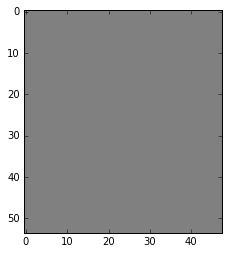

In [99]:
images = Xcv[10:11]
play_frames_clip([x.reshape(frame_dim) for x in images])

lr.predict(images)

In [100]:
import sklearn.metrics

sklearn.metrics.r2_score(ycv, lr.predict(Xcv))

1.0

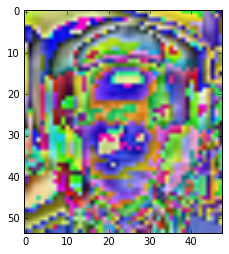

In [117]:
weights = lr.coef_.reshape(frame_dim)
play_frames_clip([normalize(weights)])

In [29]:
# Down-scale the image.
import scipy
import scipy.misc
new_shape = np.array(image.shape) / 3
new_shape[2] = 3
small_image = scipy.misc.imresize(image, new_shape)

(36, 32, 3)

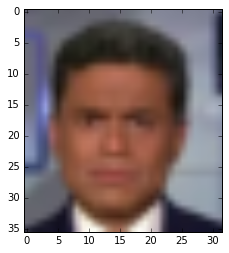

In [30]:
plt.imshow(small_image)
small_image.shape